# 🚀 COVID-19 Detection YOLOv5 3Classes [Training] 

### Hi kagglers, This is `Training` notebook using `YOLOv5`.

> 
>  [COVID-19 Detection YOLOv5 3Classes [Inference]](https://www.kaggle.com/ammarnassanalhajali/covid-19-detection-yolov5-3classes-inference)



### Please if this kernel is useful, <font color='red'>please upvote !!</font>

### Other notebooks in the competition
- [SIIM COVID-19 Detectron2 Training](https://www.kaggle.com/ammarnassanalhajali/siim-covid-19-detectron2-training)
- [SIIM COVID-19 Detectron2 Inferance](https://www.kaggle.com/ammarnassanalhajali/siim-covid-19-detectron2-inferance)
- [SIIM-FISABIO-RSNA COVID-19 Detection-EDA](https://www.kaggle.com/ammarnassanalhajali/siim-fisabio-rsna-covid-19-detection-eda)

# 📚 YOLOv5
YOLO, "You Only Look Once", has a long and succesful history with real time object detection.

#  ⬇️ Download YOLOv5
Clone this repo and install requirements.txt dependencies, including Python>=3.8 and PyTorch>=1.7.

In [ ]:
# Download YOLOv5
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

# Install dependencies
%pip install -qr requirements.txt  

# change directory
%cd ../
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

# 🔨 Weights & Biases

* Weights & Biases is a set of tools that tracks machine learning experiments, visualizes metrics, and shares results.
* Weights & Biases is directly integrated into YOLOv5, providing experiment metric tracking, model and dataset versioning, rich model prediction visualization, and more.


In [ ]:
# Install W&B 
!pip install -q --upgrade wandb

# Login 
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient() 

personal_key_for_api = user_secrets.get_secret("wandb-key")

! wandb login $personal_key_for_api


# ☀️ Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import gc
import cv2

from tqdm import tqdm
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


from IPython.core.magic import register_line_cell_magic

from os import listdir
from os.path import isfile, join
from glob import glob
import yaml

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

# 🍘 Hyperparameters

In [ ]:
TRAIN_PATH = '/kaggle/input/siim-covid19-resized-384512-and-640px/SIIM-COVID19-Resized/img_sz_512/train/'
IMG_SIZE = 512
BATCH_SIZE = 16
EPOCHS = 10

# 🍮 Loading Data
I prepared **train_image_df.csv** from [this notebook](https://www.kaggle.com/ammarnassanalhajali/siim-fisabio-rsna-covid-19-detection-eda)

In [ ]:
# Load image level csv file
df = pd.read_csv('../input/siimcovid19-detection-training-label/train_image_df.csv')
# Add absolute path
df['path'] = df.apply(lambda row: TRAIN_PATH+row.id+'.jpg', axis=1)
df.head(3)

# Only 3 Classes

In [ ]:
# remove negative class=2
df = df[df.integer_label!=2].reset_index(drop = True)

In [ ]:
df["integer_label"][df.integer_label==3]=2

In [ ]:
class_ids, class_names = list(zip(*set(zip(df.integer_label, df.y_label))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

# 🍚 Splitting Dataset

In [ ]:
# Create train and validation split.
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df.integer_label.values)

train_df.loc[:, 'split'] = 'train'
valid_df.loc[:, 'split'] = 'valid'

df = pd.concat([train_df, valid_df]).reset_index(drop=True)

In [ ]:
print(f'Size of dataset: {len(df)}, training images: {len(train_df)}. validation images: {len(valid_df)}')

## 🍚 Organize Directories

I organized train and val images and labels according to the example below.

```
/Kaggle/working
    /Covid19
         /images
             /train/img0.jpg
             /val
         /labels
             /train/img0.txt
             /val
    /yolov5
```

In [ ]:
os.makedirs('covid19/images/train', exist_ok=True)
os.makedirs('covid19/images/valid', exist_ok=True)
os.makedirs('covid19/labels/train', exist_ok=True)
os.makedirs('covid19/labels/valid', exist_ok=True)

In [ ]:
# Move the images to relevant split folder.
for i in tqdm(range(len(df))):
    row = df.loc[i]
    if row.split == 'train':
        copyfile(row.path, f'covid19/images/train/{row.id}.jpg')
    else:
        copyfile(row.path, f'covid19/images/valid/{row.id}.jpg')

# 🍜 Create `Data.YAML` file

The `data.yaml`, is the dataset configuration file that defines:

1. the dataset root directory and relative paths to train/val/test image directories (or paths to *.txt files with image paths).
1. the number of classes.
1. a list of class names.

> 📍 Note: The `data.yaml` is created in the `yolov5/data` directory as required. 

In [ ]:
with open('/kaggle/working/covid19/train.txt', 'w') as f:
    for path in glob('/kaggle/working/covid19/images/train/*'):
        f.write(path+'\n')
            
with open('/kaggle/working/covid19/val.txt', 'w') as f:
    for path in glob('/kaggle/working/covid19/images/val/*'):
        f.write(path+'\n')

data = dict(
    train = '/kaggle/working/covid19/images/train',
    val = '/kaggle/working/covid19/images/valid',
    
    nc    = 3, # number of classes
    names = classes # classes
    )

with open('/kaggle/working/yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open('/kaggle/working/yolov5/data/data.yaml', 'r')
print('\nyaml:')
print(f.read())

In [ ]:
!ls '/kaggle/working/yolov5/data'

## 🍮 Create Labels for YOLOv5

To label your images,a `.txt` file with the same name of the image,will be created (if no objects in image, no *.txt file is required)
The *.txt file specifications are:

* One row per object
* Each row is class x_center y_center width height format.
* Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
* Class numbers are zero-indexed (start from 0).

> 📍 Note: We don't have to remove the images without bounding boxes from the training or validation sets. 

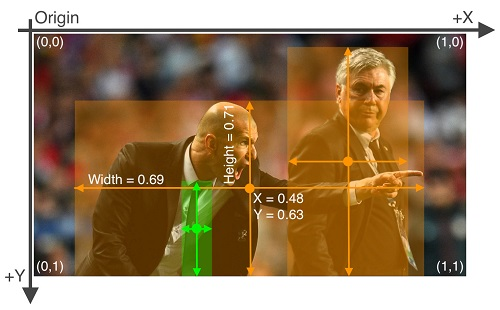

The label file corresponding to the above image contains 2 persons (class 0) and a tie (class 27):

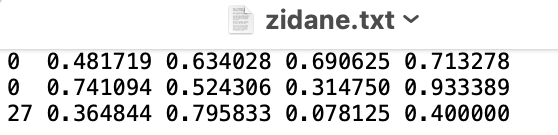

In [ ]:
# Get the raw bounding box by parsing the row value of the label column.
def get_bbox(row):
    bboxes = []
    bbox = []
    b1=row.x_min
    b2=row.y_min
    b3=row.x_max 
    b4=row.y_max 
    bbox.append(float(b1))
    bbox.append(float(b2))
    bbox.append(float(b3))
    bbox.append(float(b4))

    bboxes.append(bbox)
    
            
    return bboxes

# Scale the bounding boxes according to the size of the resized image. 
def scale_bbox(row, bboxes):
    # Get scaling factor
    scale_x = IMG_SIZE/row.width
    scale_y = IMG_SIZE/row.height
    
    scaled_bboxes = []
    for bbox in bboxes:
        x = float(bbox[0]*scale_x)
        y = float(bbox[1]*scale_y)
        x1 = float(bbox[2]*(scale_x))
        y1= float(bbox[3]*scale_y)

        scaled_bboxes.append([x, y, x1, y1]) # xmin, ymin, xmax, ymax
        
    return scaled_bboxes

# Convert the bounding boxes in YOLO format.
def get_yolo_format_bbox(img_w, img_h, bboxes):
    yolo_boxes = []
    for bbox in bboxes:
        w = bbox[2] - bbox[0] # xmax - xmin
        h = bbox[3] - bbox[1] # ymax - ymin
        xc = bbox[0] + float(w/2) # xmin + width/2
        yc = bbox[1] + float(h/2) # ymin + height/2
        
        yolo_boxes.append([xc/img_w, yc/img_h, w/img_w, h/img_h]) # x_center y_center width height
    
    return yolo_boxes

In [ ]:
dfu=df
dfuu=dfu.drop_duplicates(subset=['id'])

In [ ]:
for i in tqdm(dfuu.index):
    row = df.loc[i]
    # Get image id
    img_id = row.id
    # Get split
    split = row.split
    # Get image-level label
    label = row.integer_label   
    if row.split=='train':
        file_name = f'covid19/labels/train/{row.id}.txt'
    else:
        file_name = f'covid19/labels/valid/{row.id}.txt'
   # print(row)
    #len(df[df.id==row.id])
    ln=df[df.id==row.id].shape[0]
    with open(file_name, 'w') as f:
        for j in range(ln):
            row1 = df.loc[j]
            bboxes = get_bbox(row1)
            # Scale bounding boxes
            scale_bboxes = scale_bbox(row1, bboxes)
            # Format for YOLOv5
            yolo_bboxes = get_yolo_format_bbox(IMG_SIZE, IMG_SIZE, scale_bboxes)
            for bbox in yolo_bboxes:
                bbox = [label]+bbox
                bbox = [str(i) for i in bbox]
                bbox = ' '.join(bbox)
                f.write(bbox)
                f.write('\n')

In [ ]:
!ls covid19/labels/valid

In [ ]:
import os
list = os.listdir("./covid19/labels/train/") # dir is your directory path
number_files = len(list)
print(number_files)

In [ ]:
%cat covid19/labels/train/ffd9b6cf2961.txt

# Select a Model
Select a pretrained model to start training from. 
* Here we select YOLOv5s, the smallest and fastest model available.
* I will try YOLO5m

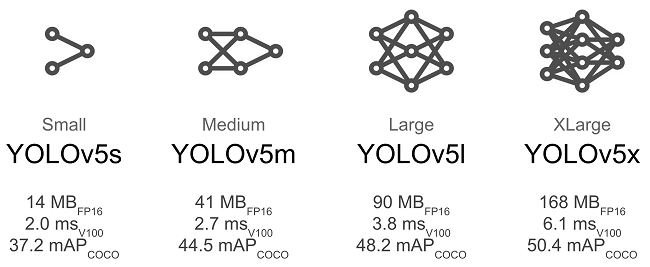

# 🚅 Train with W&B

In [ ]:
%cd yolov5/

All training results are saved to runs/train/ with incrementing run directories, i.e. runs/train/exp2, runs/train/exp3 etc. 

In [ ]:
#!WANDB_MODE="dryrun" 
!python train.py --img {IMG_SIZE} \
                 --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights yolov5m.pt \
                 --project kaggle-siim-covid19 \
                 --cache

# Removing Files

In [ ]:
%cd "../"
path = "covid19"
shutil.rmtree(path)

# 🖼️ Visualizing and Results

* Weights & Biases (W&B) is now integrated with YOLOv5 for real-time visualization and cloud logging of training runs. This allows for better run comparison and introspection, as well improved visibility and collaboration among team members.

* During training you will see live updates at https://wandb.ai, and you can create Detailed Reports of your results using the W&B Reports tool.
* To see my project on Weights & Biases (W&B) [here](https://wandb.ai/ammaralhajali/kaggle-siim-covid19)

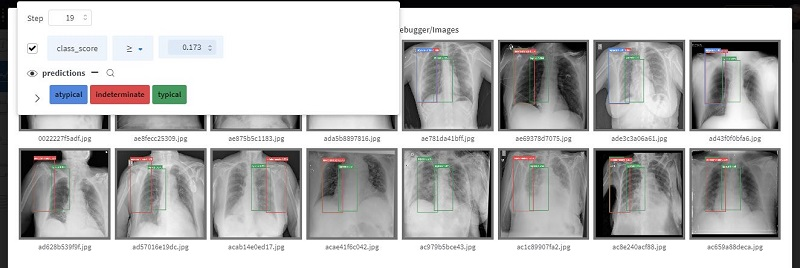

## Class Distribution

In [ ]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('./yolov5/kaggle-siim-covid19/exp/labels.jpg'));

## Batch Image

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 14))
plt.imshow(plt.imread('./yolov5/kaggle-siim-covid19/exp/train_batch0.jpg'))


In [ ]:
!ls '/kaggle/working/yolov5/kaggle-siim-covid19/exp'

# P Curve

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-siim-covid19/exp/P_curve.png'));

# PR Curve

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-siim-covid19/exp/PR_curve.png'));

# F1 Curve

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-siim-covid19/exp/F1_curve.png'));

# R Curve

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-siim-covid19/exp/R_curve.png'));

## GT Vs Pred

In [ ]:
ig, ax = plt.subplots(3, 2, figsize = (2*5,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'./yolov5/kaggle-siim-covid19/exp/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'./yolov5/kaggle-siim-covid19/exp/val_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'./yolov5/kaggle-siim-covid19/exp/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'./yolov5/kaggle-siim-covid19/exp/val_batch{row}_pred.jpg', fontsize = 12)

## (Loss, Map) Vs Epoch


In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('./yolov5/kaggle-siim-covid19/exp/results.png'));

## Confusion Matrix

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('./yolov5/kaggle-siim-covid19/exp/confusion_matrix.png'));

# Inference

In [ ]:
TEST_PATH = '/kaggle/input/siim-covid19-resized-384512-and-640px/SIIM-COVID19-Resized/img_sz_512/test/' 
weights_dir = 'kaggle-siim-covid19/exp/weights/best.pt'

In [ ]:
%cd 'yolov5'


In [ ]:
!python detect.py --weights {weights_dir} \
                  --source {TEST_PATH} \
                  --img {IMG_SIZE} \
                  --conf 0.28 \
                  --iou-thres 0.5 \
                  --max-det 3 \
                  --save-txt \
                  --save-conf \
                  --exist-ok

# Inference Plot

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import cv2
from glob import glob
from tqdm import tqdm

files = glob('runs/detect/exp/*')
for _ in range(3):
    row = 4
    col = 3
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img= cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


### Please if this kernel is useful, <font color='red'>please upvote !!</font>

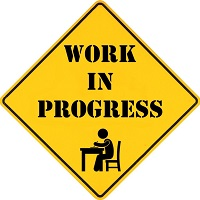

# References

1. https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data
1. https://ultralytics.com/yolov5
1. https://docs.wandb.ai/
1. https://www.kaggle.com/ayuraj/train-covid-19-detection-using-yolov5
1. https://www.kaggle.com/awsaf49/vinbigdata-cxr-ad-yolov5-14-class-train